# Architechture

## Constants

In [1]:
import numpy as np
import torch
import torch.nn as nn
from DeepFakeArchi_torch import *
from utils import *

src_path = "./workspace/data_src/aligned/"
dst_path = "./workspace/data_dst/aligned/"

weights_path = "ae_masked.pth" #will create new one
#weights_path = None #will create new one

ae_dims = 128
e_dims = 64
d_dims = 64
d_mask_dims = 16
input_ch = 3
opts = "ud"
use_fp16=False #half precision: only on GPU
resolution = 256 #512


## Data verification

data in img:  dict_keys(['face_type', 'landmarks', 'source_filename', 'source_rect', 'source_landmarks', 'image_to_face_mat', 'xseg_mask'])
torch.Size([1, 256, 256])


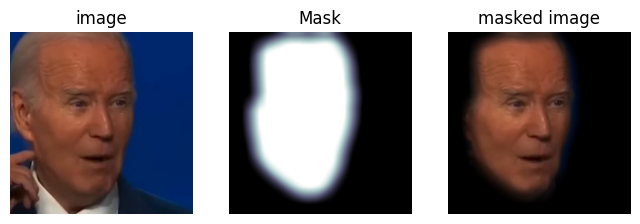

In [2]:
import matplotlib.pyplot as plt
from torchvision.transforms import GaussianBlur

blur_size = resolution//10
k_size = blur_size + 1 - blur_size%2
blur = GaussianBlur(kernel_size=(k_size,k_size),sigma=blur_size)

image = "workspace/data_dst/aligned/00015_0.jpg"
dflimg = DFLJPG.load(image)
print("data in img: ", dflimg.dfl_dict.keys())
img = dflimg.get_img()
if dflimg.has_xseg_mask():
    mask = dflimg.get_xseg_mask()
    mask = blur(mask)
    print(mask.shape)
    fig, axes = plt.subplots(1, 3, figsize=(8, 6))
    axes[0].imshow(img.permute((1,2,0)))
    axes[0].set_title("image")
    axes[0].axis("off")
    axes[1].imshow(mask.permute((1,2,0)),cmap='bone')
    axes[1].set_title("Mask")
    axes[1].axis("off")
    axes[2].imshow((img * mask).permute((1,2,0)))
    axes[2].set_title("masked image")
    axes[2].axis("off")
else:
    print("No mask data found !! ")
    plt.imshow(img.permute((1,2,0)))
    

# Training

In [11]:
### AE CLASS DEF
from torch.utils.data import Dataset
import os
import gc, itertools
from torch.utils.data import DataLoader
from pytorch_msssim import MS_SSIM, ms_ssim, SSIM, ssim
from AE import AE_model
# initializing blur for mask
from torchvision.transforms import GaussianBlur
blur_size = resolution//20
k_size = blur_size + 1 - blur_size%2
blur = GaussianBlur(kernel_size=(k_size,k_size),sigma=blur_size)


# using DSSIM from https://github.com/VainF/pytorch-msssim/blob/master/tests/ae_example/train.py 
class DSSIM_Loss(SSIM):
    def forward(self, img1, img2):
        return 100*( 1 - super(DSSIM_Loss, self).forward(img1, img2) )

class ImageSet(Dataset):
    """The simplest image loader possible"""
    def __init__(self, main_dir, masked = True, use_fp16=False):
        """Just take the folder path as input"""
        self.main_dir = main_dir
        self.masked = masked
        self.all_imgs = os.listdir(main_dir)
        self.use_fp16 = use_fp16

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        """returns Tuple (image,mask) 
        mask can be None"""
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        dflimg = DFLJPG.load(img_loc)

        image = dflimg.get_img()

        if self.masked:
            if not dflimg.has_xseg_mask: raise AttributeError(f"No mask in {img_loc} !") 
            mask = dflimg.get_xseg_mask()
        else:
            mask = torch.ones(image.shape)

        if self.use_fp16:
            image = image.half()
            mask = mask.half() 

        return image, mask

## Img loaders
masked_training = True
src_dataset = ImageSet(src_path, masked = masked_training, use_fp16=use_fp16)
dst_dataset = ImageSet(dst_path, masked = masked_training, use_fp16=use_fp16)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

if weights_path is not None:
    print(f"loading {weights_path}")
    ae_model = torch.load(weights_path)
else:
    ae_model = AE_model(
        input_ch=input_ch,
        e_dims=e_dims,
        ae_dims=ae_dims,
        d_dims=d_dims,
        d_mask_dims=d_mask_dims,
        opts=opts,
        use_fp16=False,
        )
print("number of parameters:",  count_parameters(ae_model))

loading ae_masked.pth
number of parameters: 47918778


In [4]:
gc.collect()
torch.cuda.empty_cache()

In [5]:
from torch.nn.functional import mse_loss

### TRAINING 

batch_size = 60
num_epochs = 10
# then we can create dataloader with
src_dataloader = DataLoader(src_dataset, batch_size = batch_size, shuffle=True, drop_last=True)#, num_workers = os.cpu_count()//2 )
dst_dataloader = DataLoader(dst_dataset, batch_size = batch_size, shuffle=True, drop_last=True)#, num_workers = os.cpu_count()//2 )
#TODO add num_workers = os.cpu_count()\\2 but crashed here
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-6
criterion = DSSIM_Loss(data_range=1, size_average=True, channel=3)
#criterion = nn.L1Loss()

# create optimizers
#optim = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)
optim = torch.optim.Adam( ae_model.parameters(), lr=learning_rate)
    

#send models to device
gc.collect()
torch.cuda.empty_cache()

#ae_model = AE_model(encoder,inter, decoder_dst)
ae_model.to(device)
#encoder.to(device)
#inter.to(device)
#decoder_dst.to(device)

for epoch in range(num_epochs+1):
    for (src_imgs, src_msk), (dst_imgs, dst_msk) in zip(src_dataloader, dst_dataloader):
        
        dst_imgs = dst_imgs.to(device)
        src_imgs = src_imgs.to(device)
        
        if masked_training:
            src_msk =  src_msk.to(device)
            dst_msk =  dst_msk.to(device)
            #blur masks and apply them to imgs
            dst_imgs = (dst_imgs * blur(dst_msk))
            src_imgs = (src_imgs * blur(src_msk))


        dst_code = ae_model.inter(ae_model.encoder(dst_imgs))
        dst_dec, dst_pred_msk = ae_model.decoder_dst(dst_code)
        
        src_code = ae_model.inter(ae_model.encoder(src_imgs))
        src_dec, src_pred_msk = ae_model.decoder_src(src_code)

        # blur masks
        if masked_training:
            msk_loss = mse_loss(src_pred_msk, src_msk) + mse_loss(dst_pred_msk, dst_msk)
            rec_loss_dst = criterion(dst_imgs * dst_msk, dst_dec * dst_msk )
            rec_loss_src = criterion(src_imgs * src_msk, src_dec * src_msk )
        
        else: 
            rec_loss_dst = criterion(dst_imgs,dst_dec)
            rec_loss_src = criterion(src_imgs,src_dec)
            msk_loss = 0

        loss = rec_loss_src + rec_loss_dst + 1/2*msk_loss
        # 2 Optimizers steps
        optim.zero_grad()
        loss.backward()
        optim.step()

    if epoch%10 == 0 : print(f"Epoch {epoch} | dst rec dssim {rec_loss_dst.item():.4f} | src rec dssim {rec_loss_src.item():.4f} | pred mask mse {msk_loss.item():.4f}")

print("Training Done!")

/Data/deep_face_lab/torchenv/lib/python3.11/site-packages/torchvision/transforms/_functional_tensor.py:761: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  img = conv2d(img, kernel, groups=img.shape[-3])


Epoch 0 | dst rec dssim 21.4396 | src rec dssim 17.8153 | pred mask mse 0.5198


KeyboardInterrupt: 

In [ ]:
## Save MODEL
torch.save(ae_model, "ae_masked.pth")


# Model Test

## Encoder

In [ ]:
params = sum([np.prod(p.size()) for p in encoder.parameters()])
print(encoder)
print("num of params", params)


x = torch.rand((10,input_ch,resolution,resolution))
x = src_dataset[0].unsqueeze(0)
print(x.dtype)
print("input Shape: ", x.shape)
encoded = encoder(x)
print('encoder out ch', encoder_out_ch)
print("out vec size:", encoded.shape)

## Inter

In [ ]:
import numpy as np
params = sum([np.prod(p.size()) for p in inter.parameters()])
print(inter)
print("num of params", params)
latent = inter(encoded)
print("\nout latent vec size", latent.shape)

## Decoder

In [ ]:


params = sum([np.prod(p.size()) for p in decoder_src.parameters()])
print(decoder_dst)
print("num of params", params)

decoded_src = decoder_src(latent)
print("final output image size:", decoded_src[0].shape)


# Test Trained Model

In [6]:
# to load model :
ae_model = torch.load("ae_masked.pth")

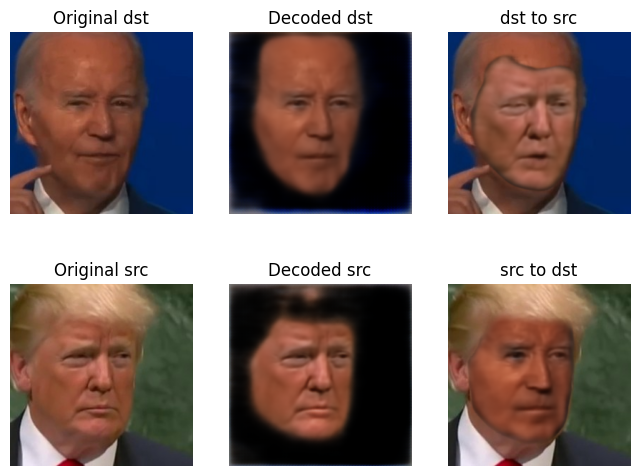

In [10]:
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ae_model.eval()
ae_model.to(device)
# load random images
dst_image, dst_mask = dst_dataset[torch.randint(0, len(dst_dataset), (1,)).item()]
src_image, src_mask = src_dataset[torch.randint(0, len(src_dataset), (1,)).item()]
dst_mask = blur(dst_mask).to(device)
src_mask = blur(src_mask).to(device)

src_image = src_image.unsqueeze(0).to(device)
dst_image = dst_image.unsqueeze(0).to(device)
dst_image_msk = (dst_image * dst_mask)
src_image_msk = (src_image * src_mask)

# Inference
with torch.no_grad():
    code_dst = ae_model.inter(ae_model.encoder(dst_image_msk))
    code_src = ae_model.inter(ae_model.encoder(src_image_msk))  
    #encoded_decoded images
    decoded_dst, _ = ae_model.decoder_dst(code_dst)
    decoded_src, _ = ae_model.decoder_src(code_src)
    #swapped faces
    decoded_dst_src, pred_dst_src_msk = ae_model.decoder_src(code_dst)
    decoded_src_dst, pred_src_dst_msk = ae_model.decoder_dst(code_src)

#readd original image -> Nope, only for reconstruction (what is happening is clearer)
#decoded_dst = (dst_image*(1 - dst_mask) + dst_mask * decoded_dst).squeeze(0).permute(1, 2, 0).cpu()
decoded_src_dst_merged = (src_image * (1-src_mask * pred_src_dst_msk) + \
                          decoded_src_dst * src_mask * pred_src_dst_msk).squeeze(0).permute(1, 2, 0).cpu()
decoded_dst_src_merged = (dst_image * (1-dst_mask * pred_dst_src_msk) + \
                          decoded_dst_src * dst_mask * pred_dst_src_msk).squeeze(0).permute(1, 2, 0).cpu()

decoded_dst = decoded_dst.squeeze(0).permute(1, 2, 0).cpu()
decoded_src = decoded_src.squeeze(0).permute(1, 2, 0).cpu()
decoded_dst_src = decoded_dst_src.squeeze(0).permute(1, 2, 0).cpu()
decoded_src_dst = decoded_src_dst.squeeze(0).permute(1, 2, 0).cpu()
# Plot the original and decoded images
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes[0,0].imshow(dst_image.squeeze().permute(1, 2, 0).cpu())
axes[0,0].set_title("Original dst")
axes[0,0].axis("off")
axes[0,1].imshow(decoded_dst)
axes[0,1].set_title("Decoded dst")
axes[0,1].axis("off")
axes[0,2].imshow(decoded_dst_src_merged)
axes[0,2].set_title("dst to src")
axes[0,2].axis("off")
axes[1,0].imshow(src_image.squeeze().permute(1, 2, 0).cpu())
axes[1,0].set_title("Original src")
axes[1,0].axis("off")
axes[1,1].imshow(decoded_src)
axes[1,1].set_title("Decoded src")
axes[1,1].axis("off")
axes[1,2].set_title("src to dst")
axes[1,2].imshow(decoded_src_dst_merged)
axes[1,2].axis("off")

plt.show()